In [1]:
library("dplyr")
library("ggplot2")
library("mgcv")
library("STRbook")
library("tidyr")
data("MOcarolinawren_long", package = "STRbook")


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: nlme


Attaching package: 'nlme'


The following object is masked from 'package:dplyr':

    collapse


This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.



In [3]:
f <- cnt ~ te(lon, lat, t,         # inputs over which to smooth
              bs = c("tp", "cr"),  # types of bases
              k = c(50, 10),       # knot count in each dimension
              d = c(2, 1))         # (s,t) basis dimension

In [4]:
cnts <- gam(f, family = nb(link = "log"),
             data = MOcarolinawren_long)

In [5]:
cnts$family$getTheta(trans = 1)

[1] 5.178305

In [6]:
MOlon <- MOcarolinawren_long$lon
MOlat <- MOcarolinawren_long$lat

## Construct space-time grid
grid_locs <- expand.grid(lon = seq(min(MOlon) - 0.2,
                                   max(MOlon) + 0.2,
                                   length.out = 80),
                         lat = seq(min(MOlat) - 0.2,
                                   max(MOlat) + 0.2,
                                   length.out = 80),
                         t = 1:max(MOcarolinawren_long$t))

In [7]:
X <- predict(cnts, grid_locs, se.fit = TRUE)

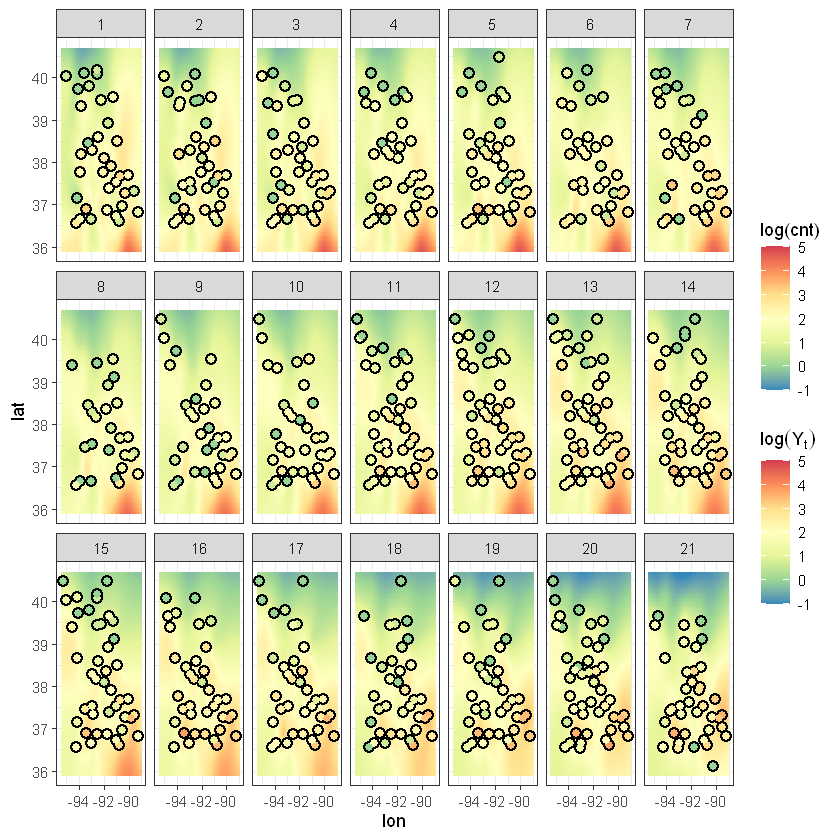

In [9]:
## Put data to plot into data frame
grid_locs$pred <- X$fit
grid_locs$se <- X$se.fit

## Plot predictions and overlay observations
g1 <- ggplot() +
    geom_raster(data = grid_locs,
                aes(lon, lat, fill = pmin(pmax(pred, -1), 5))) +
    facet_wrap(~t, nrow = 3, ncol = 7) +
    geom_point(data = filter(MOcarolinawren_long, !is.na(cnt)),
               aes(lon, lat),
               colour = "black", size = 3) +
    geom_point(data=filter(MOcarolinawren_long, !is.na(cnt)),
               aes(lon, lat, colour = log(cnt)),
               size = 2) +
    fill_scale(limits = c(-1, 5),
               name = expression(log(Y[t]))) +
    col_scale(name = "log(cnt)", limits=c(-1, 5)) +
    theme_bw()

## Plot prediction standard errors
g2 <- ggplot() +
    geom_raster(data = grid_locs,
                aes(lon, lat, fill = pmin(se, 2.5))) +
    facet_wrap(~t, nrow = 3, ncol = 7) +
    fill_scale(palette = "BrBG",
               limits = c(0, 2.5),
               name = expression(s.e.)) +
    theme_bw()

g1